In [3]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [4]:
from fastbook import *
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
path = Path('gdrive/My Drive/footprint')
dest = path
dest.mkdir(parents=True, exist_ok=True)

In [25]:
def custom_download_images(category, num_images, label):
  urls = search_images_ddg(category, max_images=num_images)
  folder = label
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True)
  download_images(dest, None, urls, num_images)

In [26]:
terms = ["bear footprint in mud"]#, "deer footprint", "dog footprint", "human footprint", "coyote footprint", "mountain lion footprint"
labels = ["bear"]#, "deer", "dog", "human", "coyote", "mountain_lion"

In [27]:
i = 0
while i < len(terms):
  custom_download_images(terms[i], 200, labels[i])
  i+= 1

In [6]:
footprint = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 get_y=parent_label,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 item_tfms=Resize(224))
dls = footprint.dataloaders(path, bs=32)

In [7]:
human_dir = os.path.join(path/'human')
deer_dir = os.path.join(path/'deer')
bear_dir = os.path.join(path/'bear')
dog_dir = os.path.join(path/'dog')

from PIL import Image

def has_transparency(img):
    if img.info.get("transparency", None) is not None:
        return True
    if img.mode == "P":
        transparent = img.info.get("transparency", -1)
        for _, index in img.getcolors():
            if index == transparent:
                return True
    elif img.mode == "RGBA":
        return True
    return False
    
def checkTypes (dir, files_array):
  for filename in files_array:
    file_path = dir + '/' + filename
    try:
      image = Image.open(file_path)
    except Image.UnidentifiedImageError:
      os.remove(file_path)
      continue
    if ((image.format != 'JPEG') and (image.format != 'PNG') and (image.format != 'GIF')):
     print("Filename: ", image.filename, " Format: ", image.format)
     image.close()
     os.remove(file_path)
     continue
    if has_transparency(image):
     print("Filename: ", image.filename, "Backround: Transparent")
     image.close()
     os.remove(file_path)
    else:
      image.close()   # close image file

human_files = os.listdir(human_dir)
checkTypes(human_dir, human_files)

deer_files = os.listdir(deer_dir)
checkTypes(deer_dir, deer_files)

bear_files = os.listdir(bear_dir)
checkTypes(bear_dir, bear_files)

dog_files = os.listdir(dog_dir)
checkTypes(dog_dir, dog_files)

In [9]:
print('total training human images:', len(os.listdir(human_dir)))
print('total training deer images:', len(os.listdir(deer_dir)))
print('total training bear images:', len(os.listdir(bear_dir)))
print('total training dog images:', len(os.listdir(dog_dir)))

total training human images: 246
total training deer images: 129
total training bear images: 287
total training dog images: 107


In [8]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(20)

/usr/local/lib/python3.9/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


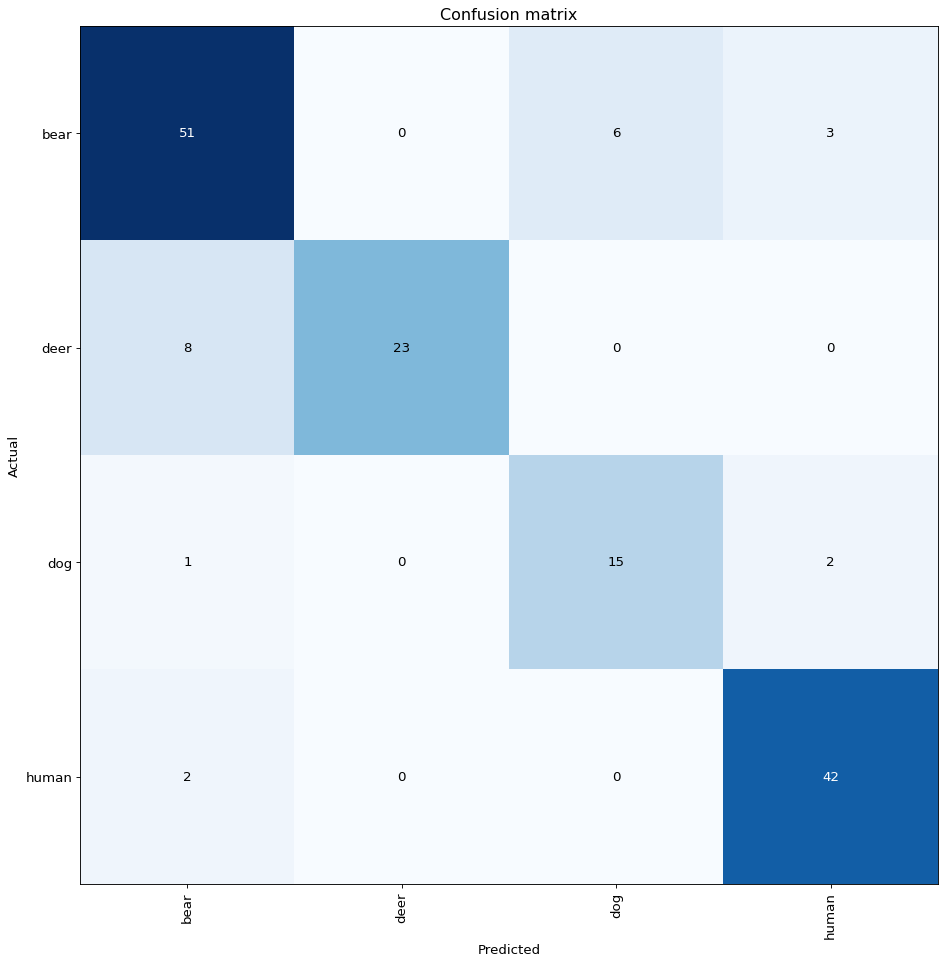

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=80)

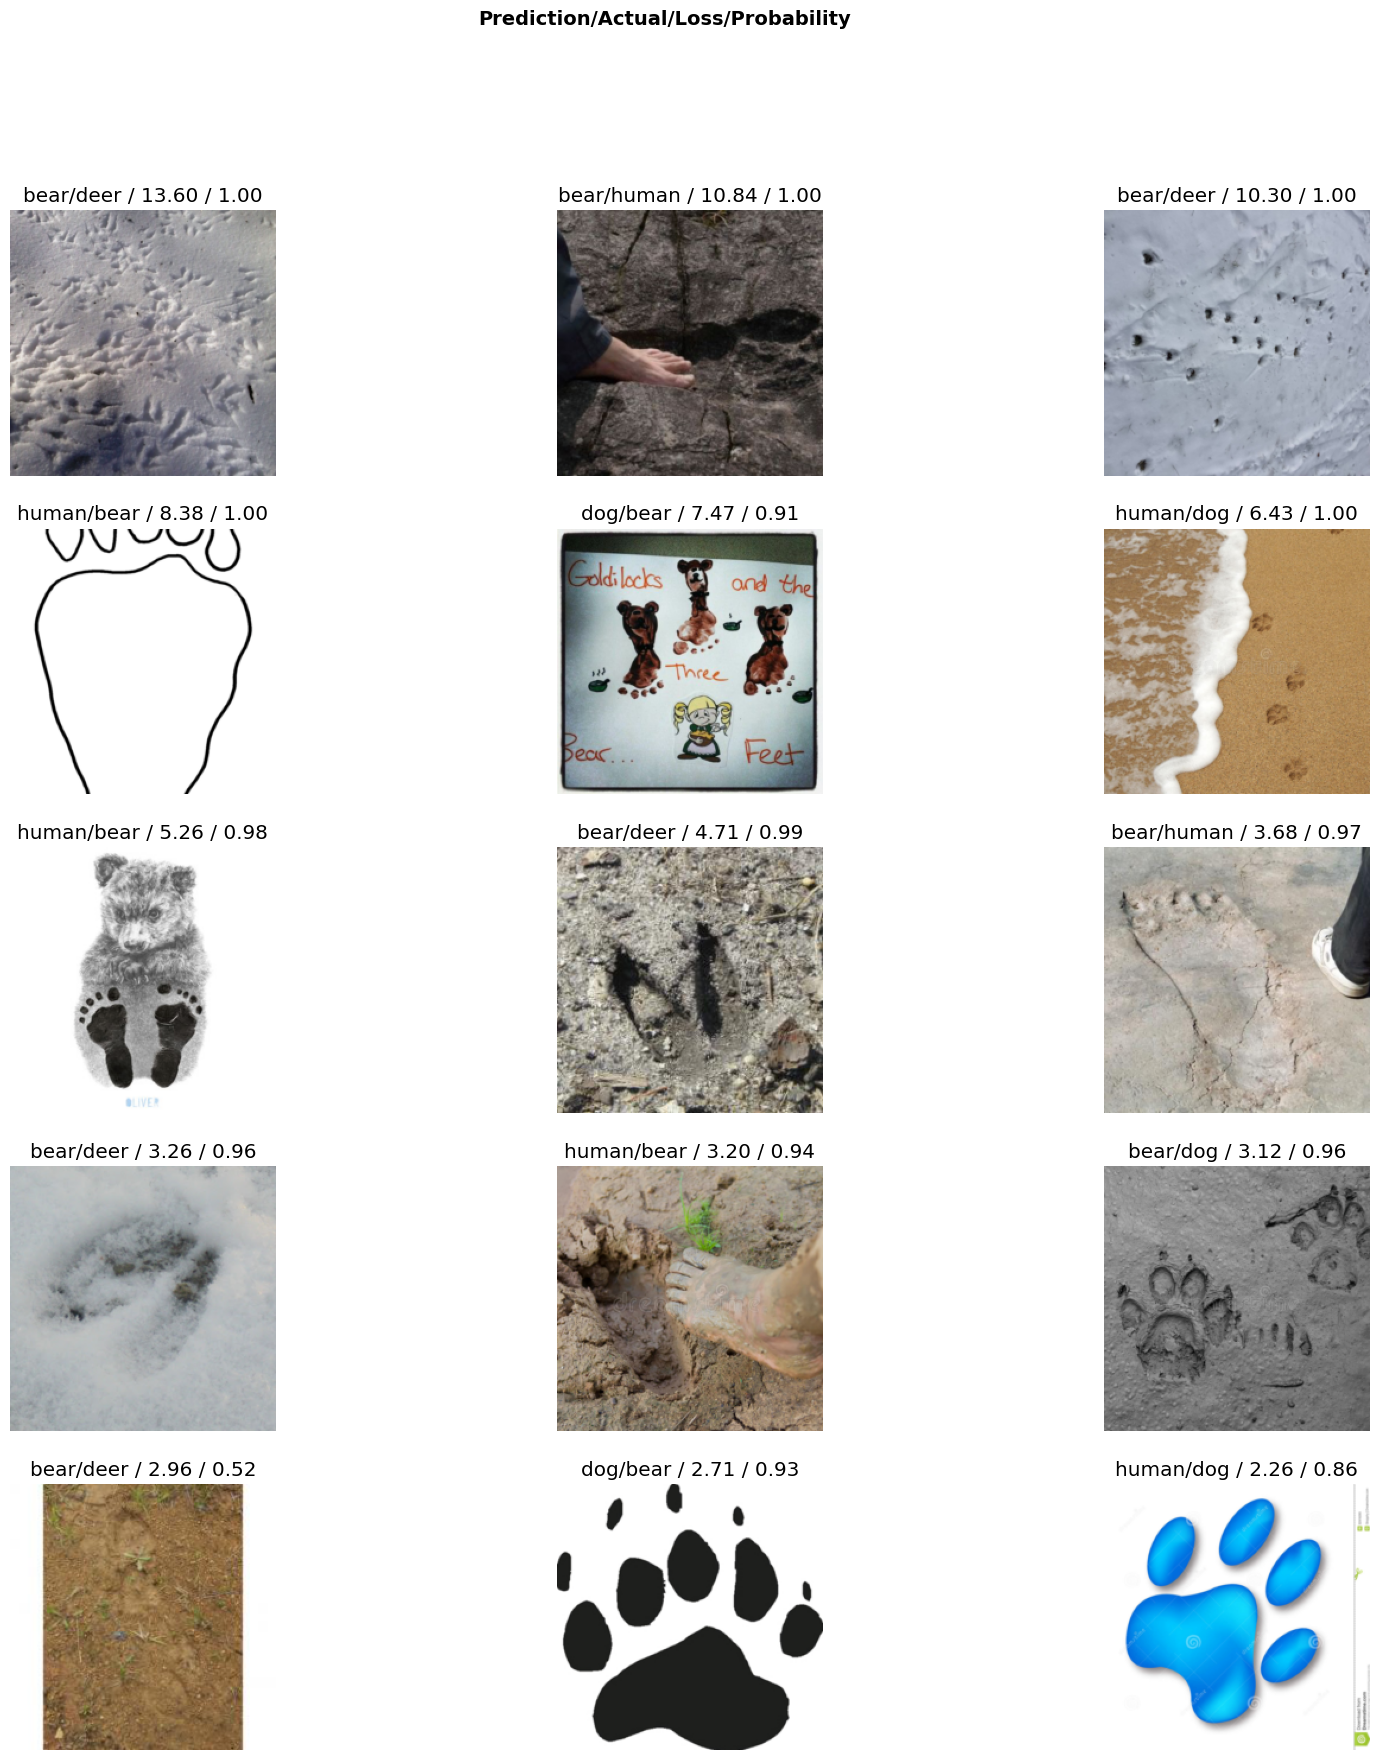

In [11]:
interp.plot_top_losses(15, nrows=5, figsize=(20,20))

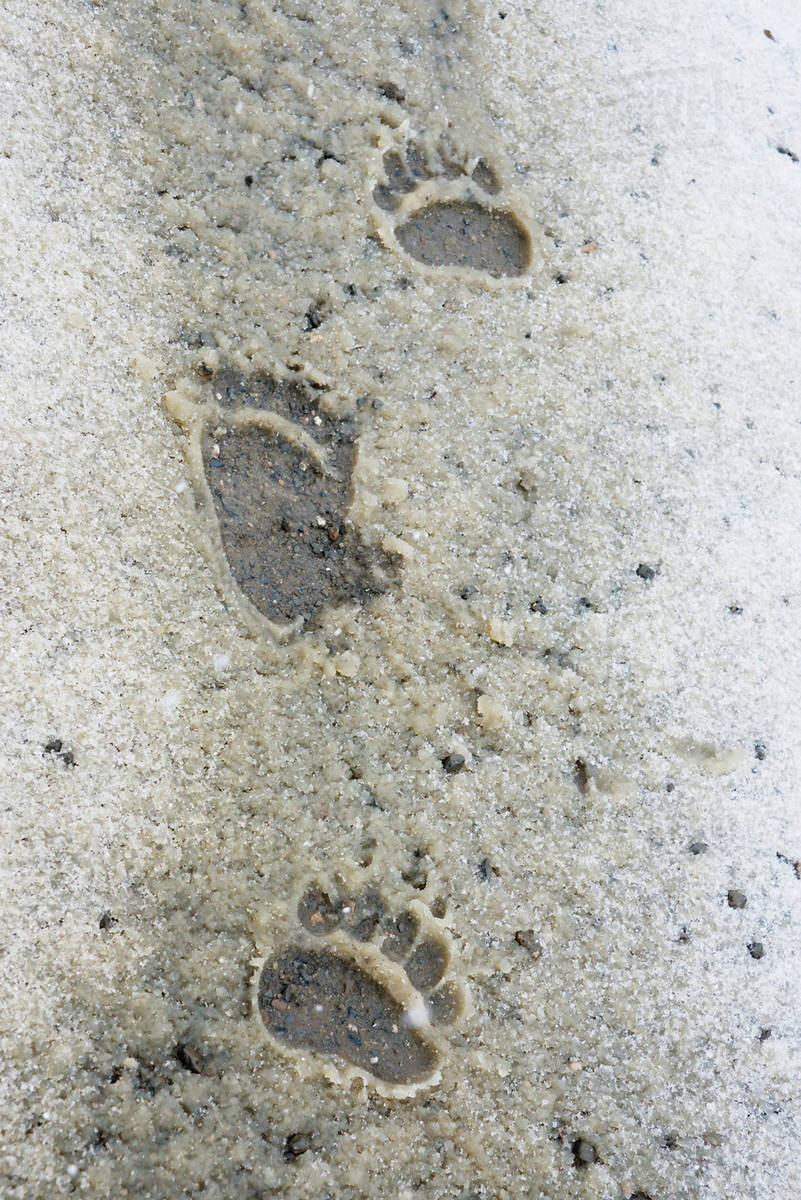

In [14]:
from PIL import Image
from urllib.request import urlopen
import io

fd = urlopen("https://cdn8.dissolve.com/p/D869_40_396/D869_40_396_1200.jpg")
image_file = io.BytesIO(fd.read())
img = Image.open(image_file).convert('RGB')
img

In [15]:
pred_class,pred_idx,probabilities = learn.predict(img)
pred_class
probabilities
pred_class, probabilities

('bear', tensor([9.3406e-01, 1.5375e-02, 5.0562e-02, 1.0685e-06]))

In [35]:
learn.export()

In [36]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [18]:
learn_inf = load_learner(path/'export.pkl')

In [22]:
path = Path('gdrive/My Drive')
learn_inf = load_learner(path/'export.pkl')

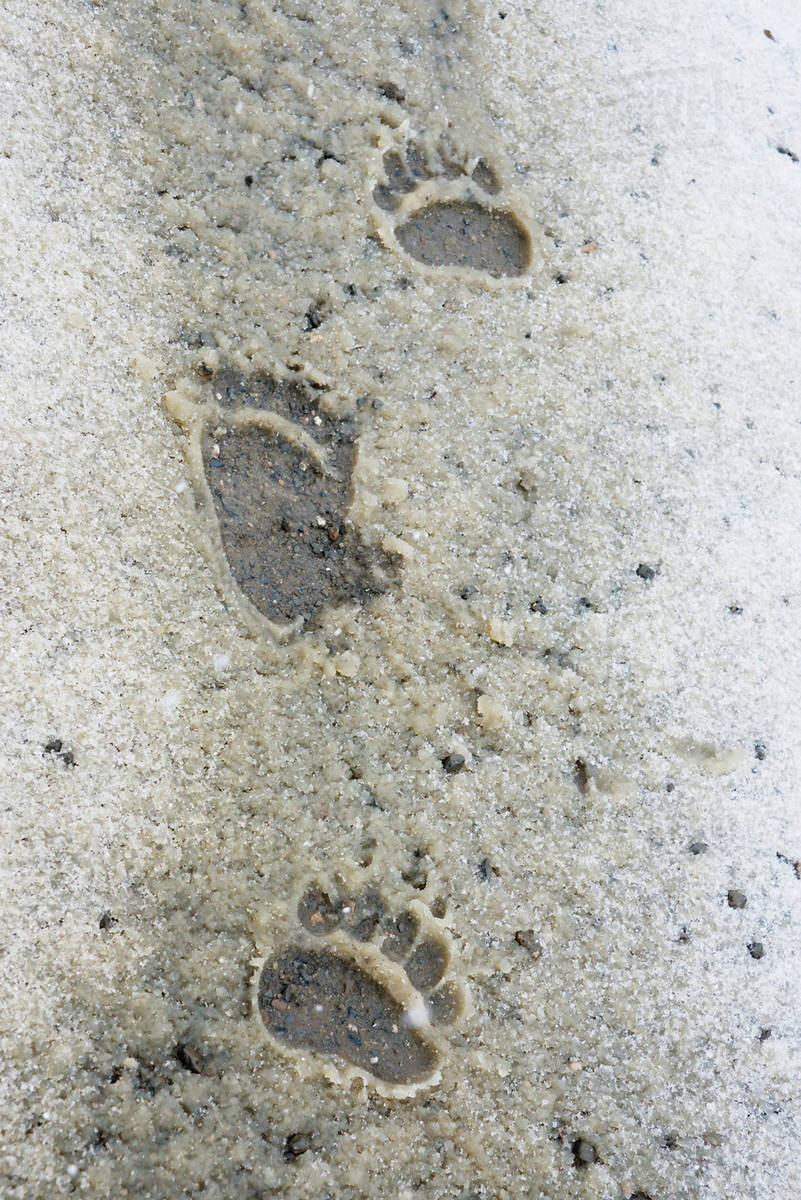

In [26]:
fd = urlopen("https://cdn8.dissolve.com/p/D869_40_396/D869_40_396_1200.jpg")
image_file = io.BytesIO(fd.read())
img = PILImage.create(image_file)
img

In [23]:
from fastai.vision.widgets import *
import ipywidgets

In [25]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [27]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [28]:
pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: bear; Probability: 0.9341')

In [29]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [30]:
def on_click_classify(change):
    img = PILImage.create([f.content.tobytes() for f in btn_upload.value][-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [31]:
VBox([widgets.Label('Select your footprint!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

AttributeError: ignored

In [33]:
from fastai.vision.all import *
from fastai.vision.widgets import *
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()
lbl_pred = widgets.Label()
def on_click_classify(change):
    img = PILImage.create([f.content.tobytes() for f in btn_upload.value][-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [34]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

AttributeError: ignored